In [ ]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
# catBoost
from catboost import CatBoostRegressor, Pool
from matplotlib.dates import DateFormatter
from sklearn.metrics import  mean_squared_error

MIN_DATE = 0


class MixTrain:
    MIN_DATE = 0
    @classmethod
    def extent_new_feature(cls, df):
        df['价格变化率'] = df['最新价'].diff() / df['最新价'].shift()
        df = df.dropna()
        # 高频偏度因子
        df['高频偏度因子'] = df['最新价'].pct_change().rolling(window=10).skew()
        # 下行波动占比因子
        price_changes = df['最新价'].pct_change()
        down_moves = price_changes.apply(lambda x: 1 if x < 0 else 0)
        df['下行波动占比因子'] = down_moves.rolling(window=10).mean()

        # 开盘后买入意愿占比因子
        df['开盘后买入意愿占比因子'] = df['买一量'].rolling(window=10).sum() / df['成交量'].rolling(window=10).sum()
        # 开盘后买入意愿强度因子
        df['开盘后买入意愿强度因子'] = df['买一量'].rolling(window=10).mean()

        # 开盘后大单净买入占比因子
        threshold = 1000 
        large_buy_orders = df['买一量'].apply(lambda x: x if x > threshold else 0)
        df['开盘后大单净买入占比因子'] = large_buy_orders.rolling(window=10).sum() / df['成交量'].rolling(window=10).sum()
                    
        return df

    @classmethod
    def get_data(cls, file_name: str):
        with open(file_name, "rb") as f:
            result = chardet.detect(f.read())

        # 获取检测到的编码格式
        encoding = result["encoding"]

        # 使用检测到的编码格式读取文件
        tick_data = pd.read_csv(
            file_name,
            encoding=encoding,
        )
        tick_data.drop(columns=["市场代码", "证券代码", "方向"], inplace=True)
        tick_data["时间"] = pd.to_datetime(tick_data["时间"])
        cls.MIN_DATE = (tick_data["时间"].min() - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
        tick_data["时间"] = (tick_data["时间"] - tick_data["时间"].min()) / np.timedelta64(1, "s")
        tick_data = tick_data.sort_values(by="时间")
        tick_data = tick_data.loc[(tick_data[["买一价", "卖一价"]] != 0).any(axis=1)]
        tick_data = tick_data.iloc[1:]  # 删除开盘前数据
        # 重新排列列的顺序
        tick_data = cls.extent_new_feature(tick_data)
#         tick_data = tick_data[[
            #  "最新价",
            # "时间",
            # "价格变化率",
            # "下行波动占比因子",
            # "开盘后买入意愿占比因子",
            # "开盘后大单净买入占比因子",
            # "高频偏度因子",
            #                 "成交笔数",
            #                 "成交额",
            #                 "成交量",
            # "开盘后买入意愿强度因子"
            #         ]]
        tick_data = tick_data[
            [
                "最新价",
                "时间",
                "成交笔数",
                "成交额",
                "成交量",
                "买一价",
                "买二价",
                "买三价",
                "买四价",
                "买五价",
                "卖一价",
                "卖二价",
                "卖三价",
                "卖四价",
                "卖五价",
                "买一量",
                "买二量",
                "买三量",
                "买四量",
                "买五量",
                "卖一量",
                "卖二量",
                "卖三量",
                "卖四量",
                "卖五量",
            ]
        ]
        tick_data = tick_data.dropna()
        return tick_data

    @classmethod
    def get_model(cls, model_name: str = "./latest_model.dump", depth=6, iterations=100, learning_rate=0.05, **params):
        try:
            model = CatBoostRegressor()
            model.load_model(model_name)
        except Exception:
            # 创建CatBoost模型
            model = CatBoostRegressor(iterations=iterations,
                                learning_rate=learning_rate,
                                depth=depth,
                                loss_function='RMSE',
                                verbose=False, 
                                random_seed=2024, 
                                od_type="Iter",
                                od_wait=100, 
                                )
        return model

    @classmethod
    def create_dataset(cls, data: pd.DataFrame, time_step=1):
        data = data.values  # 转换为Numpy数组
        X, Y = [], []
        for i in range(len(data) - time_step):
            a = data[i : (i + time_step), :-1]
            X.append(a.flatten())  # 将每个样本的特征展平
            Y.append(data[i + time_step, 0])  # 约定第一列为目标值:最新价
        return np.array(X), np.array(Y)

    @classmethod
    def _cat_train(cls, X_train, y_train, X_test, y_test, model, **params):

        # 训练模型
        train_pool = Pool(X_train, y_train)
        model.fit(train_pool, **params.get("fit", {}))

        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # 计算均方误差
        mse_train = mean_squared_error(y_train, train_predict)
        mse_test = mean_squared_error(y_test, test_predict)

        return {
            "model": model,
            "train_predict": train_predict,
            "test_predict": test_predict,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "y_train": y_train, 
            "y_test": y_test, 
            "X_train": X_train, 
            "X_test": X_test, 
        }

    @classmethod
    def _cat_k5_train(cls, X, y, model, **params):
        # 初始化五折交叉验证
        # kf = KFold(n_splits=5)
        kf = TimeSeriesSplit(n_splits=5)

        mse_tests = []
        mse_trains = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # 训练模型
            train_pool = Pool(X_train, y_train)
            model.fit(train_pool, **params.get("fit", {}))

            # 预测
            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)

            # 计算均方误差
            mse_test = mean_squared_error(y_test, test_predict)
            mse_train = mean_squared_error(y_train, train_predict)
            print(f"mse_train / mse_test: {mse_train / mse_test}")
            mse_tests.append(mse_test)
            mse_trains.append(mse_train)

        mse_train = np.mean(mse_trains)
        mse_test = np.mean(mse_tests)
        return {
            "model": model,
            "train_predict": train_predict,
            "test_predict": test_predict,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "y_train": y_train, 
            "y_test": y_test, 
            "X_train": X_train, 
            "X_test": X_test, 
        }

    @classmethod
    def train(
        cls,
        tick_data: pd.DataFrame,
        model_type: str = "catboost",
        model_name: str = "model.dump",
        time_step=10,
        is_save: bool = False,
        is_draw: bool = False,
        params=None,
        train_percent: float = 0.7
    ):
        if params is None:
            params = {}

        cls.train_percent = train_percent

        train_size = int(len(tick_data) * cls.train_percent)
        train_data, test_data = tick_data[:train_size], tick_data[train_size:]

        # 创建数据集
        def create_dataset(data, time_step):
            data = data.values  # 转换为Numpy数组
            X, Y = [], []
            for i in range(len(data) - time_step):
                a = data[i : (i + time_step), :-1]
                X.append(a.flatten())  # 将每个样本的特征展平
                Y.append(data[i + time_step, 0])
            return np.array(X), np.array(Y)

        model = cls.get_model(model_name=model_name, **params.get("init", {}))

        if model_type == "catboost":
            X_train, y_train = create_dataset(train_data, time_step)
            X_test, y_test = create_dataset(test_data, time_step)
            res = cls._cat_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, **params)
        elif model_type == "k5":
            X, y = create_dataset(tick_data, time_step)
            res = cls._cat_k5_train(X=X, y=y, model=model, **params)
        elif model_type == "CM":
            pass
            # 混淆矩阵结果验证
        else:
            return

        if is_save:
            model.save_model(model_name)
        print(f"model_type: {model_type},  mse_train / mse_test: {res['mse_train'] / res['mse_test']}")

        if is_draw:
            cls.draw(tick_data=tick_data, **res)
        return res['mse_train'] / res['mse_test']

    @classmethod
    def draw(cls, *, tick_data, y_train, train_predict, mse_train, y_test, test_predict, mse_test, time_step=10,**kargs):
        train_size = int(len(tick_data) * cls.train_percent)
        time_ticks_train = pd.to_datetime(tick_data['时间'][:train_size - time_step], unit='s')

        plt.figure(figsize=(14, 5))
        actual_price_train = y_train
        predicted_price_train = train_predict
        # 将秒数转换回时间戳
        plt.plot(time_ticks_train, actual_price_train - actual_price_train[0], color="blue", label="Actual Price - Train")
        plt.plot(time_ticks_train, predicted_price_train - predicted_price_train[0], color="red", label="Predicted Price - Train")
        # 设置x轴的格式为时分
        # date_format = DateFormatter("%H:%M")
        # plt.gca().xaxis.set_major_formatter(date_format)
        # 设置x轴的格式为时分

        plt.title(f"Training: {mse_train}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

        time_ticks = pd.to_datetime(tick_data['时间'][train_size + time_step:], unit='s')
        # 绘制测试数据的预测结果
        plt.figure(figsize=(14, 5))
        actual_price_test = y_test
        predicted_price_test = test_predict
        plt.plot(time_ticks, actual_price_test - actual_price_test[0], color="green", label="Actual Price - Test")
        plt.plot(time_ticks, predicted_price_test - predicted_price_test[0], color="purple", label="Predicted Price - Test")
        # 设置x轴的格式为时分
        # date_format = DateFormatter("%H:%M")
        # plt.gca().xaxis.set_major_formatter(date_format)

        plt.title(f"Testing: {mse_test}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
# tick_data2 = MixTrain.get_data('2.csv')
tick_data = MixTrain.get_data('tick_data.csv')


In [1]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
# catBoost
from catboost import CatBoostRegressor, Pool
from matplotlib.dates import DateFormatter
from sklearn.metrics import  mean_squared_error

MIN_DATE = 0


class MixTrain:
    MIN_DATE = 0
    @classmethod
    def extent_new_feature(cls, df):
        df['价格变化率'] = df['最新价'].diff() / df['最新价'].shift()
        df = df.dropna()
        # 高频偏度因子
        df['高频偏度因子'] = df['最新价'].pct_change().rolling(window=10).skew()
        # 下行波动占比因子
        price_changes = df['最新价'].pct_change()
        down_moves = price_changes.apply(lambda x: 1 if x < 0 else 0)
        df['下行波动占比因子'] = down_moves.rolling(window=10).mean()

        # 开盘后买入意愿占比因子
        df['开盘后买入意愿占比因子'] = df['买一量'].rolling(window=10).sum() / df['成交量'].rolling(window=10).sum()
        # 开盘后买入意愿强度因子
        df['开盘后买入意愿强度因子'] = df['买一量'].rolling(window=10).mean()

        # 开盘后大单净买入占比因子
        threshold = 1000  # 你可以根据你的需求调整这个阈值
        large_buy_orders = df['买一量'].apply(lambda x: x if x > threshold else 0)
        df['开盘后大单净买入占比因子'] = large_buy_orders.rolling(window=10).sum() / df['成交量'].rolling(window=10).sum()
                    
        return df

    @classmethod
    def get_data(cls, file_name: str):
        with open(file_name, "rb") as f:
            result = chardet.detect(f.read())

        # 获取检测到的编码格式
        encoding = result["encoding"]

        # 使用检测到的编码格式读取文件
        tick_data = pd.read_csv(
            file_name,
            encoding=encoding,
        )
        tick_data.drop(columns=["市场代码", "证券代码", "方向"], inplace=True)
        tick_data["时间"] = pd.to_datetime(tick_data["时间"])
        cls.MIN_DATE = (tick_data["时间"].min() - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
        tick_data["时间"] = (tick_data["时间"] - tick_data["时间"].min()) / np.timedelta64(1, "s")
        tick_data = tick_data.sort_values(by="时间")
        tick_data = tick_data.loc[(tick_data[["买一价", "卖一价"]] != 0).any(axis=1)]
        tick_data = tick_data.iloc[1:]  # 删除开盘前数据
        # 重新排列列的顺序
        tick_data = cls.extent_new_feature(tick_data)
        tick_data = tick_data[
            [
                "最新价",
                "时间",
                "成交笔数",
                "成交额",
                "成交量",
                "买一价",
                "买二价",
                "买三价",
                "买四价",
                "买五价",
                "卖一价",
                "卖二价",
                "卖三价",
                "卖四价",
                "卖五价",
                "买一量",
                "买二量",
                "买三量",
                "买四量",
                "买五量",
                "卖一量",
                "卖二量",
                "卖三量",
                "卖四量",
                "卖五量",
            ]
        ]
        tick_data = tick_data.dropna()
        return tick_data

    @classmethod
    def get_model(cls, model_name: str = "./latest_model.dump", depth=6, iterations=100, learning_rate=0.05, **params):
        try:
            model = CatBoostRegressor()
            model.load_model(model_name)
        except Exception:
            # 创建CatBoost模型
            model = CatBoostRegressor(iterations=iterations,
                                learning_rate=learning_rate,
                                depth=depth,
                                loss_function='RMSE',
                                verbose=False, 
                                random_seed=2024, 
                                od_type="Iter",
                                od_wait=100, 
                                )
        return model

    @classmethod
    def create_dataset(cls, data: pd.DataFrame, time_step=1):
        data = data.values  # 转换为Numpy数组
        X, Y = [], []
        for i in range(len(data) - time_step):
            a = data[i : (i + time_step), :-1]
            X.append(a.flatten())  # 将每个样本的特征展平
            Y.append(data[i + time_step, 0])  # 约定第一列为目标值:最新价
        return np.array(X), np.array(Y)

    @classmethod
    def _cat_train(cls, X_train, y_train, X_test, y_test, model, **params):

        # 训练模型
        train_pool = Pool(X_train, y_train)
        model.fit(train_pool, **params.get("fit", {}))

        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # 计算均方误差
        mse_train = mean_squared_error(y_train, train_predict)
        mse_test = mean_squared_error(y_test, test_predict)

        return {
            "model": model,
            "train_predict": train_predict,
            "test_predict": test_predict,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "y_train": y_train, 
            "y_test": y_test, 
            "X_train": X_train, 
            "X_test": X_test, 
        }

    @classmethod
    def _cat_k5_train(cls, X, y, model, **params):
        # 初始化五折交叉验证
        # kf = KFold(n_splits=5)
        kf = TimeSeriesSplit(n_splits=5)

        mse_tests = []
        mse_trains = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # 训练模型
            train_pool = Pool(X_train, y_train)
            model.fit(train_pool, **params.get("fit", {}))

            # 预测
            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)

            # 计算均方误差
            mse_test = mean_squared_error(y_test, test_predict)
            mse_train = mean_squared_error(y_train, train_predict)
            print(f"mse_train / mse_test: {mse_train / mse_test}")
            mse_tests.append(mse_test)
            mse_trains.append(mse_train)

        mse_train = np.mean(mse_trains)
        mse_test = np.mean(mse_tests)
        return {
            "model": model,
            "train_predict": train_predict,
            "test_predict": test_predict,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "y_train": y_train, 
            "y_test": y_test, 
            "X_train": X_train, 
            "X_test": X_test, 
        }

    @classmethod
    def train(
        cls,
        tick_data: pd.DataFrame,
        model_type: str = "catboost",
        model_name: str = "model.dump",
        time_step=10,
        is_save: bool = False,
        is_draw: bool = False,
        params=None,
        train_percent: float = 0.7
        
    ):
        if params is None:
            params = {}
        cls.train_percent = train_percent
        train_size = int(len(tick_data) * cls.train_percent)
        train_data, test_data = tick_data[:train_size], tick_data[train_size:]

        # 创建数据集
        def create_dataset(data, time_step):
            data = data.values  # 转换为Numpy数组
            X, Y = [], []
            for i in range(len(data) - time_step):
                a = data[i : (i + time_step), :-1]
                X.append(a.flatten())  # 将每个样本的特征展平
                Y.append(data[i + time_step, 0])
            return np.array(X), np.array(Y)

        model = cls.get_model(model_name=model_name, **params.get("init", {}))

        if model_type == "catboost":
            X_train, y_train = create_dataset(train_data, time_step)
            X_test, y_test = create_dataset(test_data, time_step)
            res = cls._cat_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, **params)
        elif model_type == "k5":
            X, y = create_dataset(tick_data, time_step)
            res = cls._cat_k5_train(X=X, y=y, model=model, **params)
        else:
            return

        if is_save:
            model.save_model(model_name)
        print(f"model_type: {model_type},  mse_train / mse_test: {res['mse_train'] / res['mse_test']}")

        if is_draw:
            cls.draw(tick_data=tick_data, **res)
        print(f"mse_train: {res['mse_train']}")
        print(f"mse_test: {res['mse_test']}")
        return res['mse_train'] / res['mse_test']

    @classmethod
    def draw(cls, *, tick_data, y_train, train_predict, mse_train, y_test, test_predict, mse_test, time_step=10,**kargs):
        train_size = int(len(tick_data) * cls.train_percent)
        time_ticks_train = pd.to_datetime(tick_data['时间'][time_step:train_size - time_step], unit='s')

        plt.figure(figsize=(14, 5))
        actual_price_train = y_train[:len(time_ticks_train)]
        predicted_price_train = train_predict[:len(time_ticks_train)]
        # 将秒数转换回时间戳
        plt.plot(time_ticks_train, actual_price_train - actual_price_train[0], color="blue", label="Actual Price - Train")
        plt.plot(time_ticks_train, predicted_price_train - predicted_price_train[0], color="red", label="Predicted Price - Train")
        # 设置x轴的格式为时分
        # date_format = DateFormatter("%H:%M")
        # plt.gca().xaxis.set_major_formatter(date_format)
        # 设置x轴的格式为时分

        plt.title(f"Training: {mse_train}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
        
        time_ticks = pd.to_datetime(tick_data['时间'][train_size + time_step:train_size + len(y_test)], unit='s')

        # 绘制测试数据的预测结果
        plt.figure(figsize=(14, 5))
        actual_price_test = y_test[:len(time_ticks)]
        predicted_price_test = test_predict[:len(time_ticks)]
        plt.plot(time_ticks, actual_price_test - actual_price_test[0], color="green", label="Actual Price - Test")
        plt.plot(time_ticks, predicted_price_test - predicted_price_test[0], color="purple", label="Predicted Price - Test")
        # 设置x轴的格式为时分
        # date_format = DateFormatter("%H:%M")
        # plt.gca().xaxis.set_major_formatter(date_format)

        plt.title(f"Testing: {mse_test}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
tick_data = MixTrain.get_data('./data/tick_data.csv')


/var/folders/b6/8729vtmx6yg24v9wj8qv5ypm0000gn/T/ipykernel_83935/1947261030.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['高频偏度因子'] = df['最新价'].pct_change().rolling(window=10).skew()
/var/folders/b6/8729vtmx6yg24v9wj8qv5ypm0000gn/T/ipykernel_83935/1947261030.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['下行波动占比因子'] = down_moves.rolling(window=10).mean()
/var/folders/b6/8729vtmx6yg24v9wj8qv5ypm0000gn/T/ipykernel_83935/1947261030.py:28: SettingWithCopyWarning: 
A value is trying to be set 

In [ ]:
from sklearn.model_selection import ParameterGrid

# 定义需要搜索的参数网格
param_grid = {
    'iterations': [100, 200, 500, 800],
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'depth': [6, 8, 10, 12],
    "time_step": [5, 8, 12, 15]
}

# 创建参数网格
grid = ParameterGrid(param_grid)

# 初始化最优参数和最小均方误差
best_params = None
min_mse = float('inf')

# 对每一组参数进行训练和测试
for params in grid:
    _time_step = params.pop("time_step")
    _p = {
        "init": params
    }
    res = MixTrain.train(time_step=_time_step,tick_data=tick_data, params=_p)
    print(f"res: {res}, _time_step: {_time_step}.  params: {params}")
    # 如果测试集上的均方误差更小，就更新最优参数
    if abs(1-res) < abs(min_mse):
        min_mse = res
        best_params = params

print('Best parameters:', best_params)


model_type: catboost,  mse_train / mse_test: 1.0001124810868463


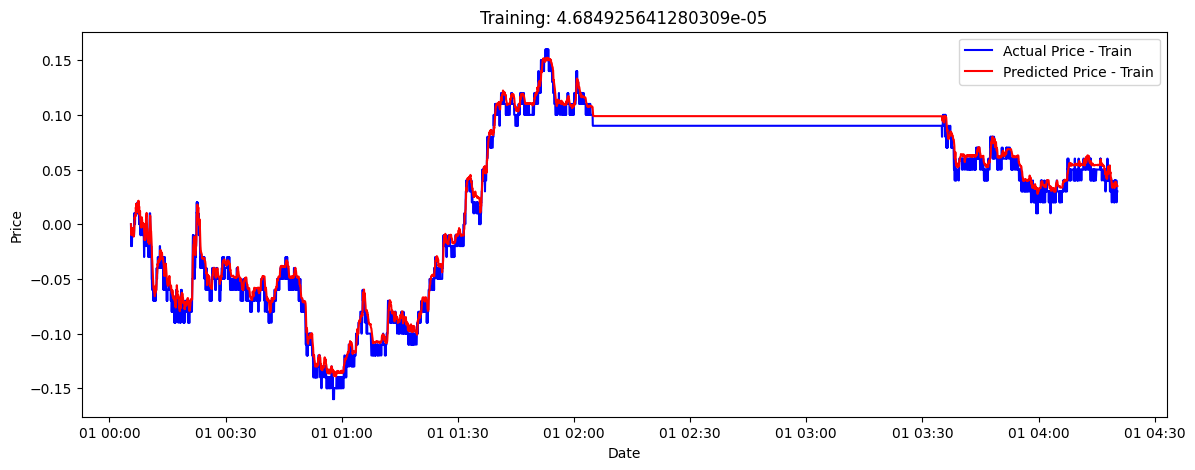

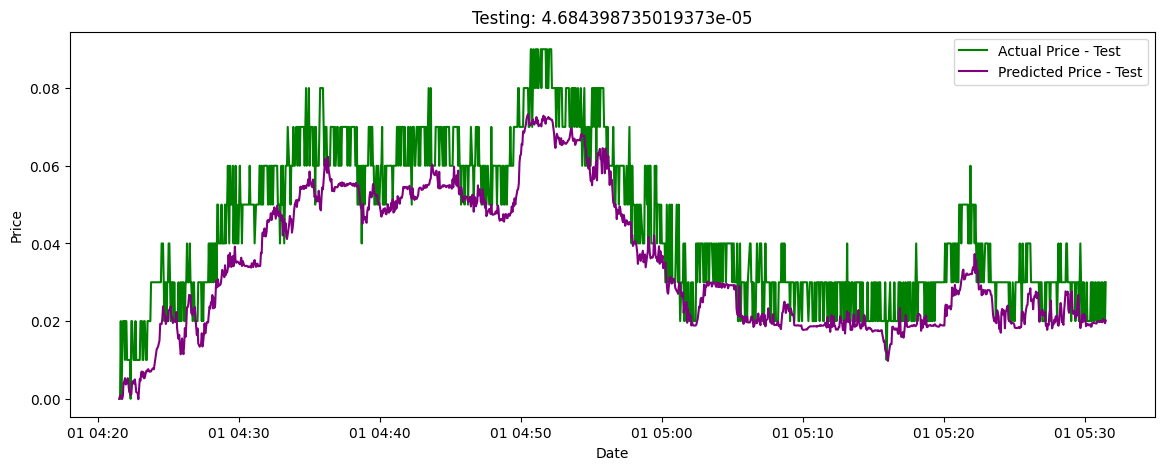

mse_train: 4.684925641280309e-05
mse_test: 4.684398735019373e-05


1.0001124810868463

In [2]:
best_params = {'depth': 8, 'iterations': 100, 'learning_rate': 0.05}
MixTrain.train(time_step=10,tick_data=tick_data, params=best_params, is_draw=True)

mse_train / mse_test: 0.028700657425851983
mse_train / mse_test: 0.004240113441271812
mse_train / mse_test: 0.8507465521908637
mse_train / mse_test: 0.8838714575457547
mse_train / mse_test: 1.0170709242887523
model_type: k5,  mse_train / mse_test: 0.02017214108889818


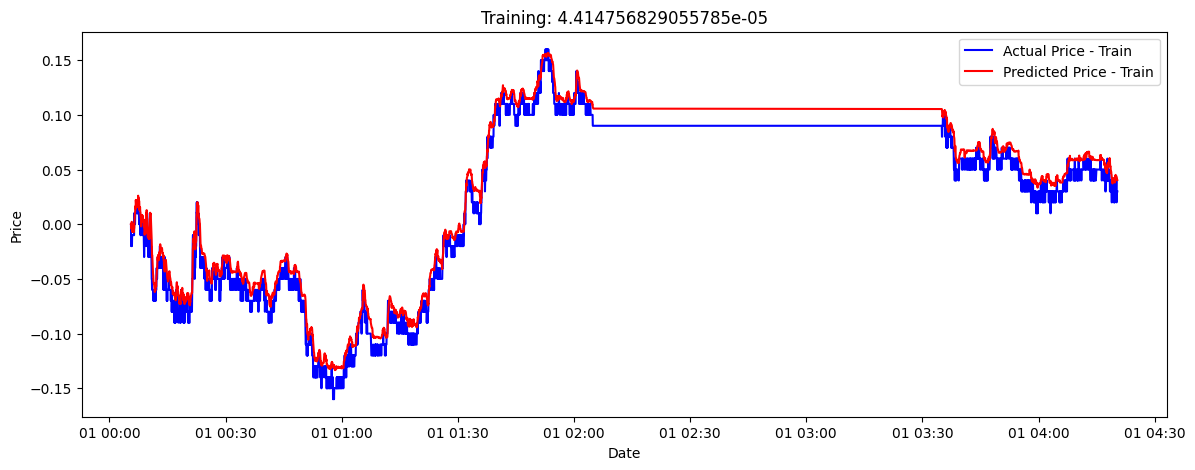

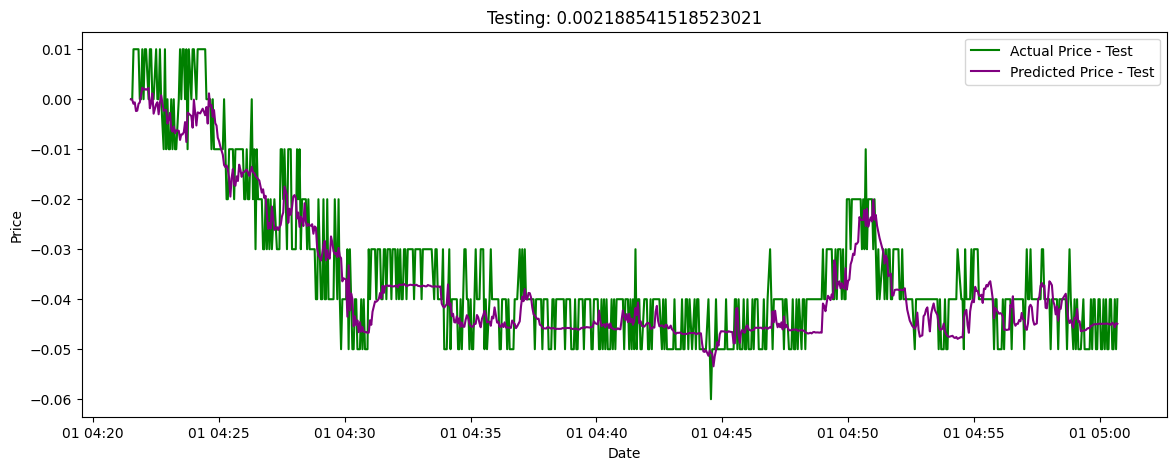

mse_train: 4.414756829055785e-05
mse_test: 0.002188541518523021


0.02017214108889818

In [40]:
best_params = {'depth': 8, 'iterations': 100, 'learning_rate': 0.05}
MixTrain.train(time_step=10,tick_data=tick_data, params=best_params, is_draw=True, model_type="k5")

/var/folders/b6/8729vtmx6yg24v9wj8qv5ypm0000gn/T/ipykernel_56066/1999306029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['高频偏度因子'] = df['最新价'].pct_change().rolling(window=10).skew()
/var/folders/b6/8729vtmx6yg24v9wj8qv5ypm0000gn/T/ipykernel_56066/1999306029.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['下行波动占比因子'] = down_moves.rolling(window=10).mean()
/var/folders/b6/8729vtmx6yg24v9wj8qv5ypm0000gn/T/ipykernel_56066/1999306029.py:28: SettingWithCopyWarning: 
A value is trying to be set 

model_type: catboost,  mse_train / mse_test: 0.12549926248786036


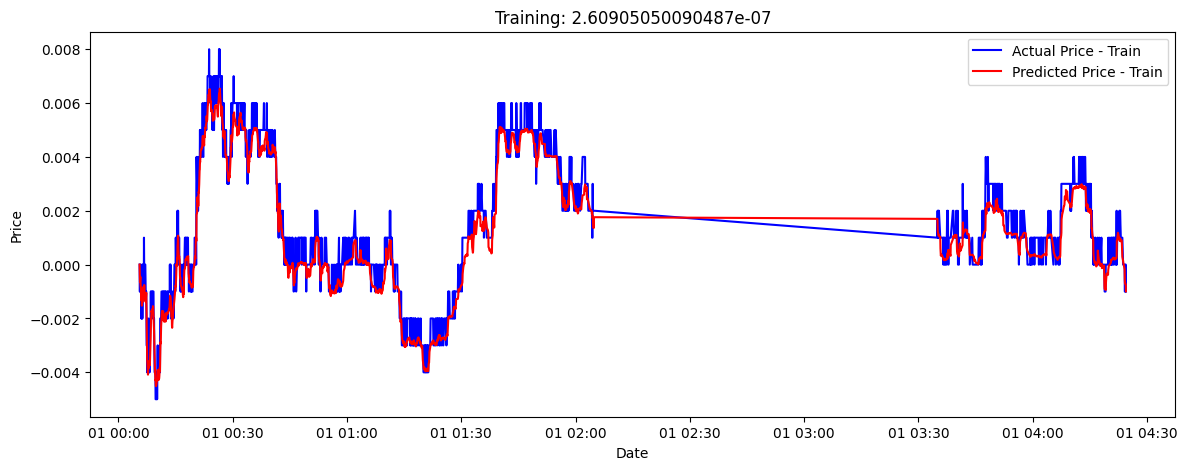

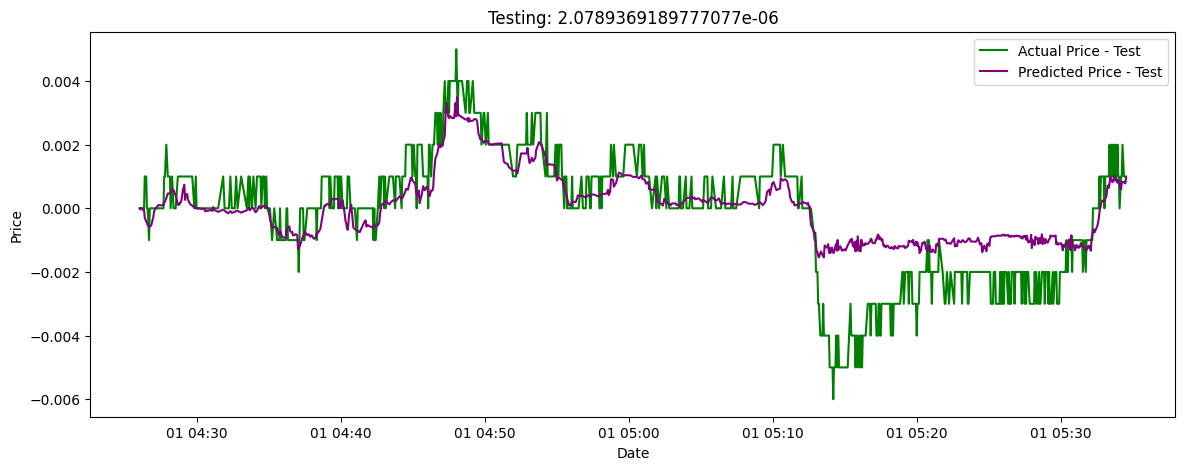

mse_train: 2.60905050090487e-07
mse_test: 2.0789369189777077e-06


0.12549926248786036

In [45]:
tick_data2 = MixTrain.get_data('./data/2.csv')
best_params = {'depth': 8, 'iterations': 100, 'learning_rate': 0.05}
MixTrain.train(time_step=10,tick_data=tick_data2, params=best_params, is_draw=True)